In [18]:
from kuramoto.SDL_SVP import SDL_SVP
from kuramoto.SDL_BCD import SDL_BCD
from kuramoto.SNMF import SNMF
from kuramoto.nmf import *

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

In [6]:
sampling_alg = 'pivot'

ntwk = 'UCLA26' # COVID_PPI, Wisconsin87, Caltech36, UCLA26
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
save_folder = 'images/'
k = 50

path = "../Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 20467
num edges in G 1495226


num of subgraphs induced on k-paths: 900
X.shape (2500, 900)


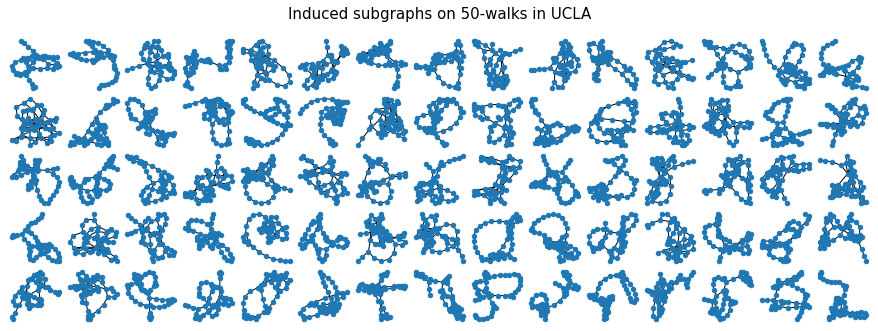

In [7]:
X, embs = G.get_patches(k=k, sample_size=900, skip_folded_hom=True)

display_graphs(title='Induced subgraphs on {}-walks in {}'.format(k, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X, embs],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

In [8]:
graph_list = generate_nxg(X)
print(f"num of graphs: {len(graph_list)}")

num of graphs: 900


In [16]:
nodes = int(np.sqrt(X.shape[0]))
df = pd.DataFrame()
K = 5

for G in graph_list:
        
    if nx.is_connected(G):

        adj_mat = nx.to_numpy_array(G)
        temp = pd.DataFrame(np.array(nx.adjacency_matrix(G).todense().flatten('C')))
        
        model = Kuramoto(coupling=K, dt=0.01, T=18, n_nodes=nodes, half_sync=False)

        sim = model.run(adj_mat)
        arr = sim.T[-1]
        conc = pd.DataFrame(pd.Series(synchronization(arr)), columns=['Synchronized'])
            
        temp = pd.concat([temp, conc], axis=1)

        df = pd.concat([df, temp], ignore_index=True)
    
df

,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,Synchronized
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,False
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
896,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
897,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
898,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,False


In [17]:
print(f"% of synchronized cases: {sum(df['Synchronized'])/len(df)}")

% of synchronized cases: 0.23333333333333334


In [43]:
X = df.drop(['Synchronized'], axis=1).values
Y = df['Synchronized'].values.reshape(-1,1)

In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.33)

In [63]:
iteration1 = 200 # Iteration for logistic training
xi_list = [0, 0.1, 1, 5, 10] # Trade-off parameters
beta = 1
iter_avg = 4
r = 32

SNMF_AUC_array = np.zeros(shape=[iter_avg, len(xi_list)]) 

for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        SNMF_class_new = SNMF(X=[X_train.T, Y_train.T],
                              X_test=[X_test.T, Y_test.T],
                              n_components=r,
                              xi=xi,
                              L1_reg = [0,0,0],
                              L2_reg = [0,0,0],
                              nonnegativity=[True,True,False],
                              full_dim=False)

        results_dict_new_snmf_cv = SNMF_class_new.train_logistic(iter=iteration1, 
                                                                 subsample_size=None, 
                                                                 beta = beta,
                                                                 search_radius_const=1,
                                                                 update_nuance_param=False,
                                                                 if_compute_recons_error=False, 
                                                                 if_validate=False)

        SNMF_AUC_array[i, j] = results_dict_new_snmf_cv.get('Accuracy')

xi_SNMF = xi_list[np.argmax(np.sum(SNMF_AUC_array, 0))]

initial loading beta [[ 0.0280049  -0.38532278  0.81972861  0.81194815  0.75102639  0.45645521
  -0.66645559  0.78878615 -0.63353111 -0.07257134 -0.34959698  0.32711166
  -0.71275598 -0.14064157 -0.00317544  0.27593452 -0.57303252 -0.83020142
   0.13941628  0.9747025  -0.70789857 -0.60766712  0.27567551  0.7116331
  -0.56066899  0.35783456  0.21465428  0.09020844 -0.5701443  -0.46625438
  -0.85474151 -0.2193951  -0.91159243]]


100%|█████████████████████████████████████████| 200/200 [00:22<00:00,  8.92it/s]


initial loading beta [[ 0.9827223   0.18705176 -0.86130301  0.57573432  0.77828743  0.5418214
   0.36195736 -0.3702276  -0.28235324  0.77660821 -0.96021626 -0.12030468
   0.18262585  0.52876715  0.37329906  0.29211702  0.91875025 -0.23935806
  -0.63254001  0.11874283  0.89862076 -0.37902836  0.3721604   0.27471825
   0.91291905  0.72216214  0.65649158  0.15190713 -0.67637629 -0.21164325
  -0.8708821   0.21305205  0.26557647]]


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.29it/s]


initial loading beta [[ 0.04741333  0.80088049 -0.54912776 -0.5825608   0.57558556 -0.74411565
  -0.4155581  -0.79953064  0.39593641  0.66334277 -0.286676   -0.41323585
   0.61617226 -0.11993753 -0.84755945  0.62646343 -0.44910307  0.33186642
  -0.45061498 -0.96171413  0.94512037  0.00214711  0.67479357  0.40375262
   0.70928257  0.03771344  0.4669724   0.32257402 -0.4911364  -0.19605335
  -0.72272251  0.87459344 -0.0684048 ]]


100%|█████████████████████████████████████████| 200/200 [00:17<00:00, 11.39it/s]


initial loading beta [[ 0.53942016  0.54403077  0.26189474 -0.9293083   0.91812089  0.23115729
   0.23956223  0.65218179  0.15338883  0.00718426 -0.87185268 -0.17359613
  -0.17768589  0.58223302  0.73103416  0.87686009  0.26952585 -0.96127647
   0.43816443  0.84174338 -0.75039495  0.16658223 -0.31359621  0.49482403
  -0.6299824  -0.32801359  0.52241256 -0.66841104  0.62318825  0.49659893
  -0.88018638  0.68358591 -0.61015752]]


100%|█████████████████████████████████████████| 200/200 [00:17<00:00, 11.15it/s]


initial loading beta [[-0.61149224  0.80163911  0.11596269 -0.68067282  0.75323105 -0.29109694
   0.49708606  0.76828632 -0.95182184  0.10388361 -0.53681297  0.60384433
  -0.28667466  0.05006193 -0.85805803 -0.3575077  -0.42171628  0.94155778
   0.66937195  0.41024423 -0.25545375 -0.42001747 -0.16592106 -0.42050746
   0.26563621  0.30386287 -0.03834158  0.83247935  0.25829876  0.08171064
   0.13539107 -0.45256064 -0.78737982]]


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.22it/s]


initial loading beta [[ 0.40363797 -0.24378398 -0.31580262  0.60334141 -0.90161049  0.95572172
  -0.57623921 -0.46907558 -0.59117646 -0.99380752 -0.81401728  0.09416854
  -0.67685628  0.07488469  0.67058135  0.88614379 -0.09653424  0.96414074
  -0.76422899 -0.84172531  0.71000638  0.2466268  -0.34109197  0.12663175
   0.96822381  0.17325033 -0.88434371  0.05512299 -0.42803941 -0.27920865
  -0.35199153  0.4948872  -0.44915192]]


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.05it/s]


initial loading beta [[-0.24814738  0.2868015  -0.37199706 -0.4667732   0.53850487  0.54661149
   0.37294465  0.65485908 -0.44838068 -0.74180016  0.97891912  0.54830811
   0.73104055  0.83479534  0.77667258  0.46519527 -0.52504626 -0.30664775
   0.67614387  0.73083428  0.29426142 -0.04328291  0.52158692 -0.33853207
   0.17343704  0.49448838  0.64235867 -0.74854738 -0.91157524 -0.0696592
   0.86429149 -0.81335649 -0.79573932]]


100%|█████████████████████████████████████████| 200/200 [00:20<00:00,  9.93it/s]


initial loading beta [[ 0.1139259   0.10439626 -0.03012856 -0.95059777  0.39636176 -0.1220685
   0.46061888 -0.12772126 -0.70738639 -0.46061895  0.77146054 -0.33314245
  -0.09786686 -0.98596655 -0.60915634  0.18465393 -0.32516313 -0.93737508
   0.62460758  0.46390836  0.75332925 -0.95737675  0.34791404  0.0336879
  -0.22864901 -0.54199778  0.58520865 -0.24502742 -0.44063125 -0.84846922
  -0.28036622 -0.63871109  0.37368629]]


100%|█████████████████████████████████████████| 200/200 [00:18<00:00, 10.96it/s]


initial loading beta [[ 0.77373001  0.87530488  0.61781986 -0.477754    0.92634054  0.08786353
   0.64451519 -0.16864507  0.4701418   0.03671585 -0.95860185 -0.41297587
  -0.48968439 -0.98717577 -0.44900226  0.15097321 -0.37739767  0.87141167
  -0.8567385   0.14850585  0.09379249  0.49784402 -0.03646557 -0.19914101
  -0.04265258 -0.25170541  0.14177775 -0.47195526 -0.07460636 -0.95460219
   0.56258998  0.42728347 -0.00855681]]


100%|█████████████████████████████████████████| 200/200 [00:17<00:00, 11.19it/s]


initial loading beta [[-0.60728985  0.79353084 -0.72491785 -0.28119866  0.20386708 -0.69267157
  -0.63568387 -0.49477655  0.54386712  0.92485035  0.066293    0.57807585
   0.57030635  0.61951529  0.50064683 -0.24571521  0.15905397 -0.61782384
   0.81708854  0.78920489  0.28861422  0.10519841 -0.73868946 -0.98964185
   0.92147196 -0.32983656  0.55844984  0.30601839  0.87745777  0.62253652
  -0.41578937  0.40402874 -0.08368941]]


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.42it/s]


initial loading beta [[-0.75231928 -0.72845673  0.58715865 -0.10960718 -0.50005249 -0.2959987
   0.76054214  0.48510727 -0.57676842  0.33126612 -0.14951267  0.30024399
  -0.46988981 -0.80101193  0.32490011 -0.10362025 -0.27812367  0.28741319
   0.74458234 -0.03802456  0.53904877  0.96116243  0.71364453  0.84853095
  -0.44380384  0.29647053 -0.1554356   0.4316415   0.1189199   0.54223602
  -0.63533977  0.67868541 -0.05026858]]


100%|█████████████████████████████████████████| 200/200 [00:18<00:00, 10.79it/s]


initial loading beta [[ 0.83426864  0.39265293  0.26706602  0.55898443  0.07782368  0.61788362
  -0.37013311 -0.99501647 -0.91843916 -0.14675365 -0.19501376  0.87784609
   0.70717602 -0.48939293  0.48734832 -0.71275885 -0.46253936  0.27552128
  -0.03217036  0.7043279   0.66268917  0.28616244 -0.41704588  0.14989065
   0.01588912 -0.55976144  0.49334256 -0.44512579  0.46617825  0.18625139
   0.27049955 -0.21361383 -0.5536151 ]]


100%|█████████████████████████████████████████| 200/200 [00:17<00:00, 11.32it/s]


initial loading beta [[ 0.1389342   0.50723976 -0.55447867  0.91176134  0.91019334  0.18172994
   0.24620091  0.16719757 -0.47471901  0.90036441 -0.31849378 -0.63036468
   0.80983259 -0.33023252 -0.98192154  0.76327431 -0.9892138  -0.02553216
   0.27552199  0.04786725  0.82974864  0.65411989 -0.43405283 -0.32178678
   0.1853425  -0.90601882  0.91195058 -0.17290185  0.14670782 -0.60707097
  -0.9720655  -0.94605799  0.05041118]]


100%|█████████████████████████████████████████| 200/200 [00:18<00:00, 10.91it/s]


initial loading beta [[ 0.75004902  0.09368749  0.34624298  0.52901594  0.78338131 -0.32431824
   0.69345729  0.85928446  0.09674913 -0.30713018 -0.85213628 -0.38565541
   0.46070358  0.12820917 -0.34408968  0.17971048 -0.61207418 -0.98708009
  -0.48085676  0.43402876 -0.96999842 -0.85435255 -0.80669719 -0.19462567
   0.95008415  0.17897914 -0.56646449  0.09836867 -0.4144056   0.24278918
  -0.84039926  0.3040708  -0.68615563]]


100%|█████████████████████████████████████████| 200/200 [00:17<00:00, 11.45it/s]


initial loading beta [[-0.73274682 -0.34464239 -0.2330286   0.0970123   0.91445498  0.58168906
  -0.00892562  0.30404622 -0.42763196 -0.02639228 -0.30740672 -0.13836147
  -0.73793521 -0.49872355 -0.10939067 -0.63770666  0.91972321  0.09998138
  -0.98864607 -0.39563714  0.83980503  0.75673788 -0.22231148 -0.09677833
   0.10026263  0.59336841  0.44518909 -0.98442245 -0.2960797  -0.6240398
   0.23895724 -0.84088213 -0.08516828]]


100%|█████████████████████████████████████████| 200/200 [00:17<00:00, 11.13it/s]


initial loading beta [[-0.84096052  0.2138531  -0.33114804 -0.52511655 -0.0243694  -0.31907715
  -0.67692695  0.35516985 -0.44156069 -0.13791965 -0.34024055  0.60809927
  -0.53733713 -0.04273185  0.64574033 -0.60108148 -0.03687707 -0.23875233
   0.84896004 -0.87940085 -0.86078337  0.0302602   0.11192154 -0.35183113
   0.55087925 -0.24315557  0.56635066  0.94882872 -0.17761886  0.26968337
  -0.14179517  0.53381671  0.78776128]]


100%|█████████████████████████████████████████| 200/200 [00:17<00:00, 11.45it/s]


initial loading beta [[ 0.66916012 -0.33972901 -0.33076674 -0.13714708 -0.10858177 -0.83230875
   0.778023    0.00190418 -0.20431161 -0.2652962   0.33295782  0.42260228
   0.1837138   0.96569576 -0.10511499  0.61057095  0.52255397 -0.97399147
  -0.7962679  -0.10199255 -0.26541524  0.35440775 -0.82987735 -0.3137552
   0.94231043 -0.61178589  0.4492013  -0.20090112 -0.65429136 -0.53487661
  -0.28082141  0.30421848 -0.83263026]]


100%|█████████████████████████████████████████| 200/200 [00:18<00:00, 10.99it/s]


initial loading beta [[-0.93234821  0.52997786 -0.6681616  -0.39416364  0.27527072  0.47675123
  -0.43589298 -0.54428925  0.12966115 -0.37185902 -0.52018479 -0.64749945
  -0.70043608 -0.88725495  0.80450027  0.48689011  0.30898681  0.08328204
  -0.0066656  -0.59245174  0.65463534 -0.02686856  0.30929619  0.82629065
  -0.13393488  0.51574683 -0.447996    0.27734616 -0.2502662  -0.47764094
   0.59461232  0.20670172  0.21533091]]


100%|█████████████████████████████████████████| 200/200 [00:17<00:00, 11.19it/s]


initial loading beta [[-0.1350808  -0.62017124 -0.36803605 -0.39182346  0.45558015 -0.43614326
  -0.59329159  0.61472624  0.02239335 -0.19773405 -0.47997245  0.2481892
  -0.96639005 -0.45274394 -0.95928508 -0.07236984  0.9665046  -0.90738867
  -0.80122283 -0.42985494  0.94936003  0.9524278   0.94170228  0.37503033
  -0.24333109 -0.27613599  0.24727104 -0.09530426  0.08862257  0.98174607
  -0.48206682  0.01906981  0.86131094]]


100%|█████████████████████████████████████████| 200/200 [00:17<00:00, 11.35it/s]


initial loading beta [[ 0.7282007  -0.76693862 -0.29211189 -0.19774237  0.77957976  0.95048464
   0.06553328  0.24816162  0.76691688 -0.8304023  -0.82807915 -0.09525471
  -0.01569804  0.71207161  0.81582999 -0.90729598 -0.35794476 -0.38349524
   0.68664376 -0.696514   -0.5617016   0.56341732  0.6659243  -0.80912583
  -0.15552544  0.17937369 -0.57435412 -0.41621293 -0.0709688  -0.0470161
   0.89742832  0.51231643  0.00986048]]


100%|█████████████████████████████████████████| 200/200 [00:18<00:00, 11.00it/s]


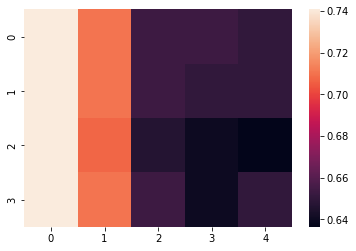

In [68]:
import seaborn as sns
sns.heatmap(SNMF_AUC_array);

In [71]:
results_dict_new_snmf_cv

{'xi': 10,
 'L1_reg': [0, 0, 0],
 'L2_reg': [0, 0, 0],
 'nonnegativity': [True, True, False],
 'n_components': 32,
 'loading': [array([[0.00000000e+00, 0.00000000e+00, 3.59428946e-07, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.81203004e-02, 1.72255654e-02, 1.70309744e-02, ...,
          1.76719638e-02, 1.70436923e-02, 1.77151253e-02],
         [2.15168131e-03, 2.00516440e-03, 2.02946066e-03, ...,
          1.88155733e-03, 2.12123106e-03, 2.03104282e-03],
         ...,
         [2.94503258e-03, 2.94761371e-03, 2.75793611e-03, ...,
          2.50928442e-03, 2.82059497e-03, 2.65981158e-03],
         [1.81219094e-02, 1.72242178e-02, 1.70301073e-02, ...,
          1.76712912e-02, 1.70440173e-02, 1.77151892e-02],
         [9.23630686e-08, 2.36260177e-07, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
  array([[-8.02728183,  0.09785911,  0.1217433 ,  0.1076521 ,  0.10982251,
           0.11234054,  0.07674017,  0.19777283,  0

In [80]:
results_dict_new_snmf_cv['loading'][1]

array([[-8.02728183,  0.09785911,  0.1217433 ,  0.1076521 ,  0.10982251,
         0.11234054,  0.07674017,  0.19777283,  0.12597316,  0.13379248,
         0.12054745,  0.10217587,  0.12350521,  0.1045245 ,  0.13325467,
         0.12007627,  0.13931039,  0.10695123,  0.11058896,  0.12350718,
         0.13453285,  0.08923512,  0.11882405,  0.10302833,  0.12002067,
         0.11924001,  0.14097713,  0.09958197,  0.1227681 ,  0.1366391 ,
         0.14470356,  0.11609138,  0.12175032]])

In [81]:
results_dict_new_snmf_cv['loading'][0].shape

(2500, 32)

In [85]:
results_dict_new_snmf_cv['code'].shape

(32, 603)

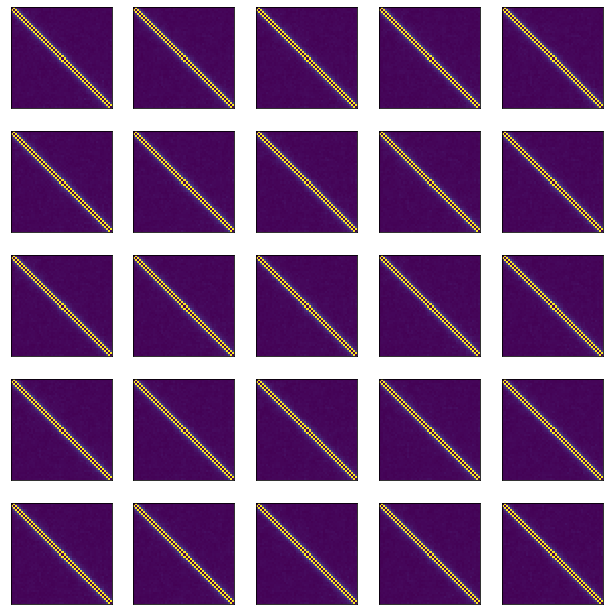

In [92]:
display_dictionary(W = results_dict_new_snmf_cv['loading'][0],
                   figsize=[10,10])